**Student ID:** Erik Iuhas 101076512
# HandyKeys Training and Validation Code

This notebook contains the models for training the HandyKeys Classifiers and testing 

# Mount for Training
Training is done using my Google Drive. It will not be possible for you to test my training on your own google drive unless you set up the folder the same way as I did in at my drive link:  https://drive.google.com/drive/folders/1Tj5QfndOj4xlEvG-CxJihrJdXRqfIokj?usp=sharing

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

folder_path = "drive/MyDrive/HandyKeys/Dataset"

Mounted at /content/drive


# Import Required Libraries (REQUIRED)
In this code block we are importing Tensorflow and Keras along with other libraries needed for training.

In [1]:
import os
import numpy as np
import cv2 as cv
import tensorflow as tf
import numpy as np
from PIL import Image
from itertools import cycle
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Setup Training and Validation Paths
If testing ensure you have the files at the specified within your Google Drive 

In [3]:
train_hand_1 = os.path.join(folder_path + '/train/Hand1')
train_hand_2 = os.path.join(folder_path + '/train/Hand2')
train_hand_3 = os.path.join(folder_path + '/train/Hand3')
train_hand_4 = os.path.join(folder_path + '/train/Hand4')
train_hand_5 = os.path.join(folder_path + '/train/Hand5')
train_hand_6 = os.path.join(folder_path + '/train/Hand6')
train_hand_7 = os.path.join(folder_path + '/train/Hand7')
train_none = os.path.join(folder_path + '/train/None')


validation_hand_1 = os.path.join(folder_path + '/validation/Hand1')
validation_hand_2 = os.path.join(folder_path + '/validation/Hand2')
validation_hand_3 = os.path.join(folder_path + '/validation/Hand3')
validation_hand_4 = os.path.join(folder_path + '/validation/Hand4')
validation_hand_5 = os.path.join(folder_path + '/validation/Hand5')
validation_hand_6 = os.path.join(folder_path + '/validation/Hand6')
validation_hand_7 = os.path.join(folder_path + '/validation/Hand7')
validation_none = os.path.join(folder_path + '/validation/None')



# Initialize Dataset and Validation Set

In [4]:
# set the size for the images being trained on.
image_size = 256

# apply data augmentation (Flip, and shift height and width) and regularize the photos to be within 0 to 1
train_datagen = ImageDataGenerator(rescale= 1./255,horizontal_flip = True,height_shift_range=0.1,width_shift_range=0.05,fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale= 1./255,horizontal_flip = True,height_shift_range=0.1,width_shift_range=0.05,fill_mode='nearest')

#select the batch size and initialize folders for training
train_generator = train_datagen.flow_from_directory(
        folder_path + '/train/',  # training image directory
        classes = ['Hand1', 'Hand2','Hand3', 'Hand4','Hand5', 'Hand6','Hand7', 'None'],
        target_size=(image_size, image_size),  
        batch_size=22, # Because there are 792 images, we will use a batch size of 22
        class_mode= 'categorical', # using categorical because we have 8 classes
        shuffle=True)

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        folder_path + '/validation/',  # training image directory
        classes = ['Hand1', 'Hand2','Hand3', 'Hand4','Hand5', 'Hand6','Hand7', 'None'],
        target_size=(image_size, image_size), 
        batch_size=6, # Because there are 168 images, we will use a batch size of 6
        # Use binary labels
        class_mode= 'categorical', # using categorical because we have 8 classes
        shuffle=False)

Found 792 images belonging to 8 classes.
Found 168 images belonging to 8 classes.


# Create VGG Network Architecture

Following the architecture for Configuration A we are attempting to make a VGG network. 

In [16]:
vgg_16_base = tf.keras.models.Sequential([

#First Layer, Convolution using the size of the image with depth 64
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
tf.keras.layers.MaxPooling2D(),

#Second Layer, Convolution with depth 128
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

#Third Layer, Convolution with depth 256
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

#Fourth Layer, Convolution with depth 512
tf.keras.layers.Conv2D(512, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(512, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

#Fifth Layer, Convolution with depth 512
tf.keras.layers.Conv2D(512, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(512, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(4096, activation='relu'),
tf.keras.layers.Dense(8, activation='softmax')]) # Hot ones encoding for 8 values

# Display Network Architecture

In [17]:
vgg_16_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 256)      

# Setup Checkpoints

In [13]:
checkpoint_path = "/tmp/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Initialize checkpoints
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=25) #save every batch

vgg_16_base.save_weights(checkpoint_path.format(epoch=0))


# Begin Training Classifier

In [19]:
vgg_16_base.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [20]:
results = vgg_16_base.fit(train_generator,
      steps_per_epoch=36,  # because we have 792 training images and a batch size of 22 we need 36 steps per epoch
      epochs=35, # train for 30 epochs
      verbose=1,
      validation_data = validation_generator,
      callbacks = [cp_callback],
      validation_steps=28) # because we have 168 training images and a batch size of 6 we need 28 steps per epoch

Epoch 1/35
24/36 [===================>..........] - ETA: 3s - loss: 0.6032 - accuracy: 0.1212 - recall_2: 0.0038
Epoch 1: saving model to /tmp/cp-0001.ckpt
36/36 [==============================] - 23s 609ms/step - loss: 0.5300 - accuracy: 0.1212 - recall_2: 0.0025 - val_loss: 0.3815 - val_accuracy: 0.1250 - val_recall_2: 0.0000e+00
Epoch 2/35
13/36 [=========>....................] - ETA: 7s - loss: 0.3853 - accuracy: 0.0839 - recall_2: 0.0000e+00
Epoch 2: saving model to /tmp/cp-0002.ckpt
36/36 [==============================] - 20s 565ms/step - loss: 0.3829 - accuracy: 0.1023 - recall_2: 0.0000e+00 - val_loss: 0.3801 - val_accuracy: 0.1250 - val_recall_2: 0.0000e+00
Epoch 3/35
 2/36 [>.............................] - ETA: 10s - loss: 0.3772 - accuracy: 0.1591 - recall_2: 0.0000e+00
Epoch 3: saving model to /tmp/cp-0003.ckpt
27/36 [=====================>........] - ETA: 5s - loss: 0.3808 - accuracy: 0.1212 - recall_2: 0.0000e+00
Epoch 3: saving model to /tmp/cp-0003.ckpt
36/36 [=======

# Plot Loss
Plotting the loss to determine when to stop training the network.  

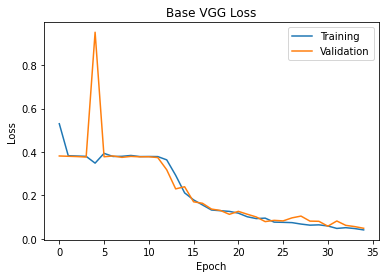

In [21]:
#Plot the loss  
plt.plot(results.history['loss']) #Testing
plt.plot(results.history['val_loss']) #validation
#labels 
plt.title('Base VGG Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot Accuracy
Plotting the accuracy to determine when the network performed best.

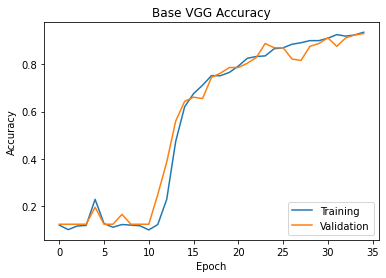

In [22]:
#Plot the loss  
plt.plot(results.history['accuracy']) #Testing
plt.plot(results.history['val_accuracy']) #Validation
#Labels
plt.title('Base VGG Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Save Weights

Save VGG weights

In [23]:
vgg_16_base.save_weights(folder_path + "/vgg_base.h5") 

# Create new Convolutional Neural Network

Due to the higher variance in perforamcne for validatiopn accuracy i am looking to make a more shallow CNN network including dropout layers to improve the performance and increase regularization. I am looking to do this because the application will be running on a local computer and if the model is too large it won't be able to make inferences fast enough to be considered useful.  

# New Network - TinyHand

The machine learning network that I will construct will be called TinyHand going further. This is because it will be a smaller CNN and Hand comes from the Project name "HandyKeys" 

In [24]:
tiny_hand = tf.keras.models.Sequential([

#First Layer, First Layer remains the same
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization

#Second Layer, Convolution with depth 32
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization 

#Third Layer, Convolution with depth 64
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization

#Fourth Layer, Convolution with depth 128 Increasing the count of Conv to 3
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization 

#Fifth Layer, Convolution with depth 256
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(2048, activation='relu'), #Reduce Dense layer to 2048
tf.keras.layers.Dense(8, activation='softmax')]) # Hot ones encoding for 8 values

# TinyHand Summary
As seen in the summary we've reduced the number of parameters by 

In [25]:
tiny_hand.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 32)      18464     
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                 

# Prepare Checkpoints

In [26]:
checkpoint_path = "/tmp/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Initialize variables for checkpoint testing 
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=25) #save every batch

tiny_hand.save_weights(checkpoint_path.format(epoch=0))


# Begin Training TinyHand

Because TinyHand is a smaller network it will likely take more time for it to reach an optimal loss, to account for this the epohcs were increased to 50 improve learning. This was also found out by earlier training where the loss was still occuring during the original length of 35. 

In [27]:
tiny_hand.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [28]:
results_tiny = tiny_hand.fit(train_generator,
      steps_per_epoch=36,  # because we have 792 training images and a batch size of 22 we need 36 steps per epoch
      epochs=50, # train for 50 epochs
      verbose=1,
      validation_data = validation_generator,
      callbacks = [cp_callback],
      validation_steps=28) # because we have 168 training images and a batch size of 6 we need 28 steps per epoch

Epoch 1/50
24/36 [===================>..........] - ETA: 3s - loss: 0.6322 - accuracy: 0.1477 - recall_3: 0.0227
Epoch 1: saving model to /tmp/cp-0001.ckpt
36/36 [==============================] - 16s 411ms/step - loss: 0.5508 - accuracy: 0.1376 - recall_3: 0.0152 - val_loss: 0.3882 - val_accuracy: 0.1250 - val_recall_3: 0.0000e+00
Epoch 2/50
13/36 [=========>....................] - ETA: 7s - loss: 0.3823 - accuracy: 0.1538 - recall_3: 0.0000e+00
Epoch 2: saving model to /tmp/cp-0002.ckpt
36/36 [==============================] - 14s 393ms/step - loss: 0.3811 - accuracy: 0.1275 - recall_3: 0.0000e+00 - val_loss: 0.3800 - val_accuracy: 0.1250 - val_recall_3: 0.0000e+00
Epoch 3/50
 2/36 [>.............................] - ETA: 10s - loss: 0.3831 - accuracy: 0.0909 - recall_3: 0.0000e+00
Epoch 3: saving model to /tmp/cp-0003.ckpt
27/36 [=====================>........] - ETA: 3s - loss: 0.3794 - accuracy: 0.1162 - recall_3: 0.0000e+00
Epoch 3: saving model to /tmp/cp-0003.ckpt
36/36 [=======

# Plot Loss
Plotting the loss to determine when to stop training the network.  

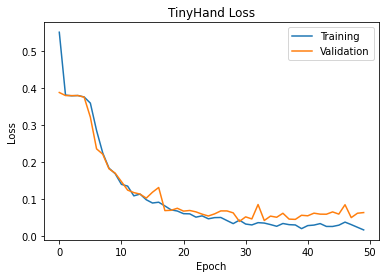

In [29]:
#Plot the loss  
plt.plot(results_tiny.history['loss']) #Testing Loss
plt.plot(results_tiny.history['val_loss']) #Validation Loss

#Labels
plt.title('TinyHand Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot Accuracy
Plotting the accuracy to determine when the network performed best.

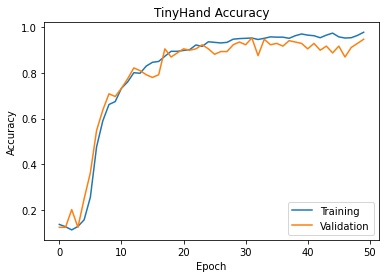

In [30]:
#Plot the accuracy  
plt.plot(results_tiny.history['accuracy']) #Testing Accuracy
plt.plot(results_tiny.history['val_accuracy']) #Validation Accuracy
#Add Labels 
plt.title('TinyHand Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [31]:
tiny_hand.save_weights(folder_path + "/tiny_hand_final.h5")

# Build TinyHand Architecture (REQUIRED)
Repeating the tiny_hand structure above. You need to run this section in order to load the weights from the "tiny_hand_final.h5" weights. 

In [2]:
image_size = 256
tiny_hand = tf.keras.models.Sequential([

#First Layer, First Layer remains the same
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization

#Second Layer, Convolution with depth 32
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization 

#Third Layer, Convolution with depth 64
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization

#Fourth Layer, Convolution with depth 128 Increasing the count of Conv to 3
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(128, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2), #Indroducing Dropout Layers which improves regularization 

#Fifth Layer, Convolution with depth 256
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(2048, activation='relu'), #Reduce Dense layer to 2048
tf.keras.layers.Dense(8, activation='softmax')]) # Hot ones encoding for 8 values

# Load the Weight File (REQUIRED)
Ensure you upload the file into the base file directory located at the left. It should look like the image below after uploading the file. 

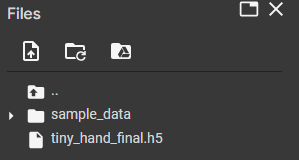

Use the weight file included in my submission in the HandyKeysApp Directory. 

You can also find the weights in my Dataset Folder at this Drive link: https://drive.google.com/drive/folders/1Tj5QfndOj4xlEvG-CxJihrJdXRqfIokj?usp=sharing

In [3]:
tiny_hand.load_weights("tiny_hand_final.h5")

# Test TinyHand (REQUIRED)

This section of the Notebook allows for you to load the model of tiny hand and the validation set that was being used in the training to check that my network is working. By using the small validation set I provided you with you can pick from the examples to upload one at a time to receive the classification and the photos or just upload all at once to recieve the classifications only.

When running you can just upload it where it says Choose Files:

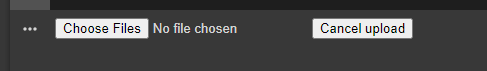

Saving 317.jpg to 317 (1).jpg
[[0. 1. 0. 0. 0. 0. 0. 0.]]
Hand is Key 2


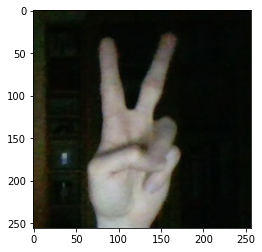

In [16]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predict hand gestures
  path = '/content/' + fn
  img = image.load_img(path, target_size=(256, 256))
  array_img = image.img_to_array(img)
  plt.imshow(array_img/255.)
  array_img = np.expand_dims(array_img, axis=0)
  images = np.vstack([array_img])
  classes = tiny_hand.predict(images, batch_size=1)
  # print hot-ones encodeing 
  print(classes)

  #select largest index
  max_index = np.argmax(classes[0])

  # Print the hand key number. 
  if max_index == 0:
    print("Hand is Key 1")
  elif max_index == 1:
    print("Hand is Key 2")
  elif max_index == 2:
    print("Hand is Key 3")
  elif max_index == 3:
    print("Hand is Key 4")
  elif max_index == 4:
    print("Hand is Key 5")
  elif max_index == 5:
    print("Hand is Key 6")
  elif max_index == 6:
    print("Hand is Key 7")
  else:
    print("No Hand. Nothing.")
